In [1]:
import numpy as np
import pandas as pd
import numpy as np
import scipy.io
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from pymongo import MongoClient
sns.set()
plt.rcParams["figure.figsize"] = (10,8)
import hiplot as hip

ModuleNotFoundError: No module named 'pymongo'

In [4]:
data = np.load("../Data/RayTracingData/Remcom_4x4_IR_100taps.npy")

In [5]:
data.shape

(23922, 16, 100)

In [6]:
hip.Experiment.from_iterable(data).display()

AttributeError: 'numpy.ndarray' object has no attribute 'get'

In [46]:
example = data[0,0,:]
data[0].shape

(16, 100)

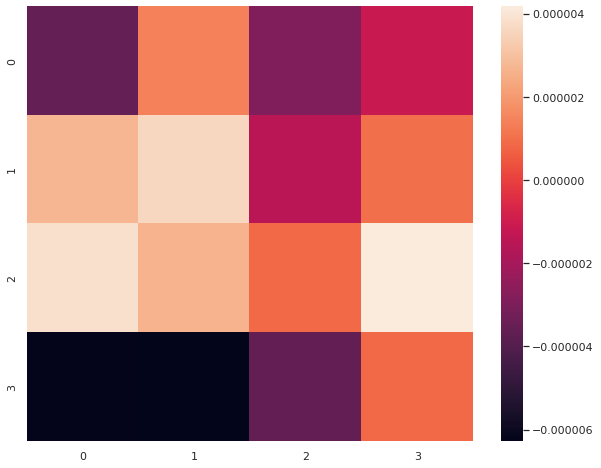

In [47]:
sns.heatmap(np.sum(np.real(data[:,:,0]), axis=0).reshape(4,4))

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

In [97]:
dataset = torch.Tensor(np.real(data)).permute(0,2,1).reshape(-1, 100 ,4, 4)*10000000

In [98]:
train, test = train_test_split(dataset)


In [100]:
train

tensor([[[[-2.2117e-05, -1.3980e-05, -5.2081e-06, -7.3179e-06],
          [-3.1203e-05, -2.4284e-05, -1.6309e-05,  4.3096e-06],
          [-3.7827e-05, -3.2617e-05, -2.6000e-05, -1.8323e-05],
          [-4.1509e-05, -3.8356e-05, -3.3541e-05, -2.7344e-05]],

         [[ 2.2488e-05,  1.4217e-05,  5.2976e-06,  7.4187e-06],
          [ 3.1709e-05,  2.4675e-05,  1.6564e-05, -4.3785e-06],
          [ 3.8432e-05,  3.3133e-05,  2.6400e-05,  1.8591e-05],
          [ 4.2170e-05,  3.8958e-05,  3.4055e-05,  2.7746e-05]],

         [[-2.2874e-05, -1.4463e-05, -5.3906e-06, -7.5219e-06],
          [-3.2235e-05, -2.5080e-05, -1.6828e-05,  4.4499e-06],
          [-3.9059e-05, -3.3666e-05, -2.6814e-05, -1.8866e-05],
          [-4.2853e-05, -3.9580e-05, -3.4585e-05, -2.8160e-05]],

         ...,

         [[-4.9261e-05, -3.0675e-05, -1.1014e-05, -1.8009e-05],
          [-7.1289e-05, -5.5598e-05, -3.7832e-05,  1.0434e-05],
          [-8.7349e-05, -7.5745e-05, -6.1238e-05, -4.4415e-05],
          [-9.6270e

In [101]:
train.shape

torch.Size([17941, 100, 4, 4])

In [102]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(100, 16, 4, stride=2, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            #nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            #nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 100, 6, stride=2, padding=1),  # b, 8, 15, 15
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [103]:
train_loader = DataLoader(train, batch_size=64)
test_loader = DataLoader(test)

In [104]:
model = AE()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [105]:
for e in range(30):
    #train
    for data in train_loader:
        model.train()
        x = Variable(data)
        #forward pass
        output = model(x)
       # print(x.shape)
       # print("Ouput shape: ", output.shape)
        train_loss = criterion(output, x)
        
        #backprop
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    #eval
    for data in test_loader:
        model.eval()
        x = Variable(data)
        output = model(x)
        test_loss = criterion(output, x)

        

    #log
    print('epoch [{}/{}], train_loss:{:.4f}'.format(e + 1, 20, train_loss.item()))
    print('epoch [{}/{}], test_loss:{:.4f}'.format(e + 1, 20, test_loss.item()))

epoch [1/20], train_loss:0.0001
epoch [1/20], test_loss:0.0000
epoch [2/20], train_loss:0.0001
epoch [2/20], test_loss:0.0000
epoch [3/20], train_loss:0.0001
epoch [3/20], test_loss:0.0000


KeyboardInterrupt: 

In [108]:
test[0].shape

torch.Size([100, 4, 4])

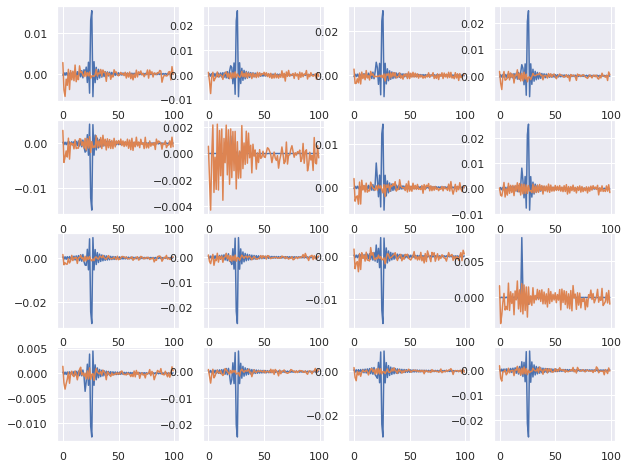

In [127]:
k=0
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i+j+1+k)
        plt.plot(test[0][:,i,j])
        plt.plot(model(test[0:1])[0][:,i,j].detach())
    k+=3